**Exercise and Lab: Pulse Shape Discrimination**

The goal of this exercise is to perform a pulse shape analysis on real data.

A scintillation detector is exposed to both neutron and gamma radiation, both emitted from a source places some half meter away from the detector. A detected particle (neutron or gamma) will result in an electrical pulse (a short signal) from the detector. However, the pulse shape of the detector signal depends looks different for both types of particles.

Together with the detector pulse, the flight time of the particle from the source to the detector is measured. (More on this in the introductory video for the lab.) Since gammas move at speed of light and neutrons don't, the flight times provide a second way of discriminating between neutrons and gammas, independent of the pulse shapes.

We start by downloading a data file. For testing there is a small data set, once everything works, there is more data...

In [ ]:
# load data
# The code snippet below is responsible for downloading the dataset
# - for example when running via Google Colab.
# It is enough to load one of the files below.

# Small data file.
import os
if not os.path.exists("data_small.npy"):
  !gdown https://drive.google.com/uc?id=1Ejrt2O6rRj0N7F29pXxsa-gELsVaGhfA

# The small data file is enough to do this exercise but if you want you can also use much more data.
# Large data file. Uncomment this line only if you really want to use all data.
# !gdown https://drive.google.com/uc?id=1AcMxtW3GFsKpkLqDLwlDxgYFtbtzcrZQ

Downloading...
From: https://drive.google.com/uc?id=1Ejrt2O6rRj0N7F29pXxsa-gELsVaGhfA
To: /content/data_small.npy
100% 229M/229M [00:00<00:00, 233MB/s]


The next step will be do load the data into a numpy array and check it, e.g. by looking at some pulses.

The data consists of a (high) number of lines, each line representing one pulse.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

data_raw = np.load('/content/data_small.npy')

# Check the size of the data file
print(data_raw.shape)
# Print the first pulse
# print(data[0])

(55686, 514)


The first number in each line is a detector identifier, which we can happily ignore here.

The second number is the flight time in nanoseconds, this provides information about the particle type, neutron or gamma.

The pulse is sampled at a rate of 1 GHz, so the remaining 512 numbers represent 512 ns of the pulse shape.

(55686, 512)


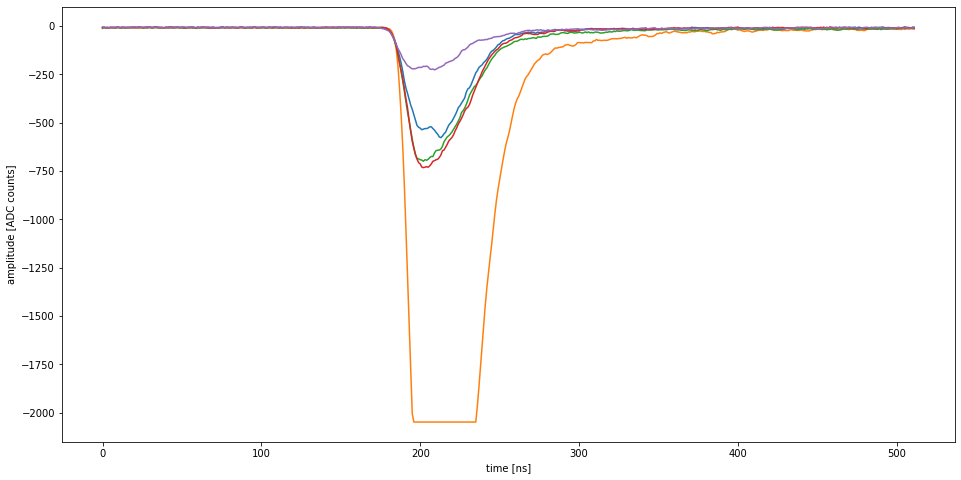

In [ ]:
# Select only the pulse shape part of the data
pulses = data_raw[:,2:]
# Prepare a figure and plot some pulses
print(pulses.shape)
fig, ax = plt.subplots(figsize=(16,8))
ax.plot(pulses[0])
ax.plot(pulses[10])
ax.plot(pulses[100])
ax.plot(pulses[1000])
ax.plot(pulses[10000])
ax.set_xlabel("time [ns]")
ax.set_ylabel("amplitude [ADC counts]")
plt.show()

We will now extract the flight times.

In [ ]:
times = data_raw[:,1]
print('Flight times between', times.min(), 'and', times.max(), 'nanoseconds.')

Flight times between -371.822 and 287.852 nanoseconds.


Negative flight times (also called times of flight, tof) are okay (for random coincidences), but we will restrict their range before plotting:

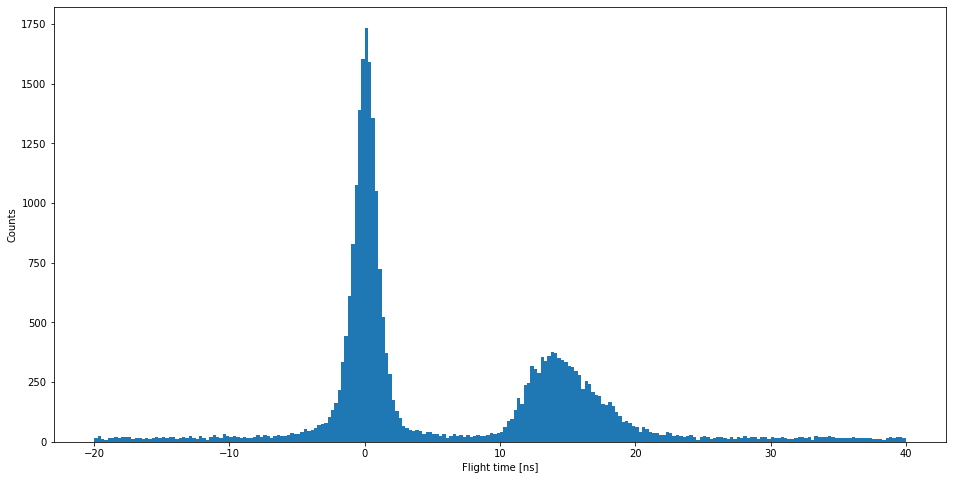

In [ ]:
min_tof = -20
max_tof = 40
times = times[(times>=min_tof) & (times<=max_tof)]
# Now create a figure
fig, ax  = plt.subplots(figsize=(16,8))
ax.hist(times, bins=240)   # high resolution: 4 bins per nanosecond
ax.set_xlabel('Flight time [ns]')
ax.set_ylabel('Counts')
plt.show()

The flight time spectrum shows a gamma peak at around 0 ns and a neutron peak at around 10 to 20 ns.
You can now define flight time ranges within which you will accept gammas and neutrons. Please adjust the numbers below according to your data and your liking.
During the exercise class, we will discuss how the choice of the limits affects your results.

In [ ]:
gamma_min_tof = -3
gamma_max_tof = 3
neutron_min_tof = 10
neutron_max_tof = 20
# gamma_min_tof = -0.5
# gamma_max_tof = 0.5
# neutron_min_tof = 13
# neutron_max_tof = 15

gammadata = data_raw[(data_raw[:,1] >= gamma_min_tof) & (data_raw[:,1] <= gamma_max_tof)]
gammapulses = gammadata[:,2:]
print('Gammas:  ', gammapulses.shape)

neutrondata = data_raw[(data_raw[:,1] >= neutron_min_tof) & (data_raw[:,1] <= neutron_max_tof)]
neutronpulses = neutrondata[:,2:]
print('Neutrons:', neutronpulses.shape)



Gammas:   (15089, 512)
Neutrons: (8690, 512)


You now have two arrays with pulse shapes, one with only gammas (according to the flight times) and one with only neutrons (again, according to the flight times). Each array contains a large number of pulse shapes, each pulse consists of 512 detector readings.

Let's start preparing the data for the training of a neural network.



In [ ]:
# make a combined data set containing both pulse types
data = np.vstack((gammapulses, neutronpulses))
labels = np.zeros(len(data), dtype=int)
labels[:len(gammapulses)] = 1
# gammas are labelled as 1, and neutrons are labelled as 0

# normalize the data
baseline = np.mean(data[:, 0:100]) # the baseline is determined from the first 100 samples that do not yet contain the signal pulse
data = (data - baseline)
min = np.min(data, axis=-1, keepdims=True)
data /= min

# reduce the size of the data
data = data[:, 150:350]
samples_per_pulse = len(data[0])

data = data[:,:, np.newaxis]

# before we split up the dataset into training, validation and test data set, we need to shuffle the events
# otherwise we end up having only one type of event in our validation and test data sets.
np.random.seed(1234)
shuffle_indices = np.arange(0, len(data), dtype=int)
np.random.shuffle(shuffle_indices)
data = data[shuffle_indices]
labels = labels[shuffle_indices]

In [ ]:
# split data up into train/validation and test data set
n_test = 2000

data_test = data[-n_test:-1]
labels_test = labels[-n_test:-1]

# we will use the keras functionality to split up the data set automatically into a training and validation data set
data_train = data[:-n_test]
labels_train = labels[:-n_test]

print(f"{len(labels_train)} event in training/validation data set, {np.sum(labels_train)} gammas, {len(labels_train) - np.sum(labels_train)} neutrons")
print(data_train.shape)
print(labels_train.shape)

21779 event in training/validation data set, 13832 gammas, 7947 neutrons
(21779, 200, 1)
(21779,)


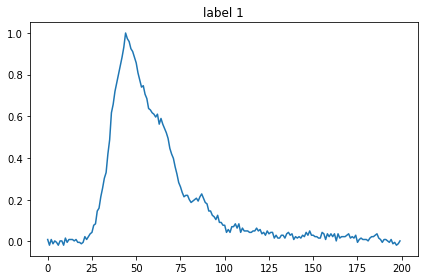

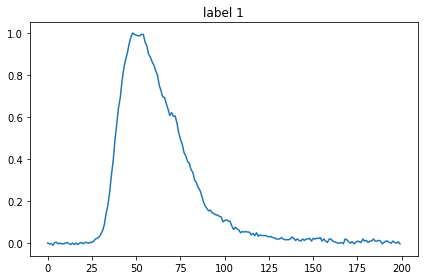

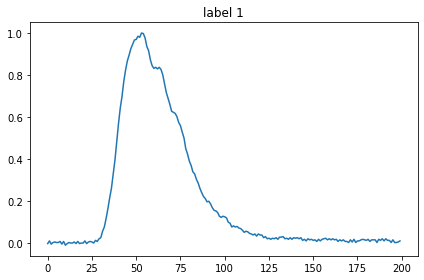

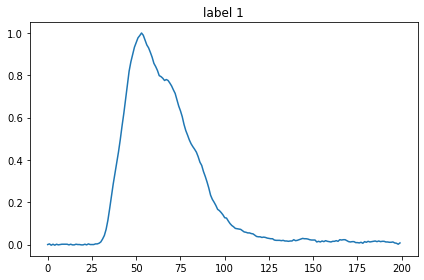

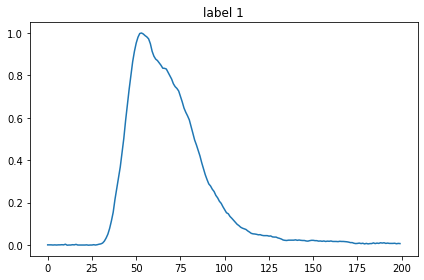

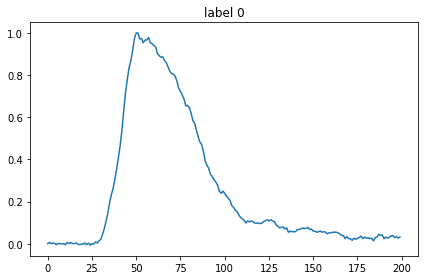

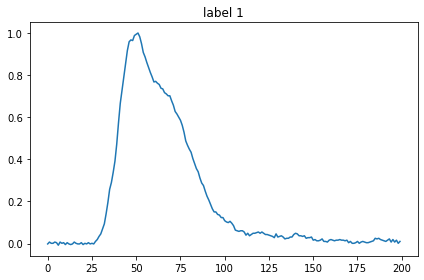

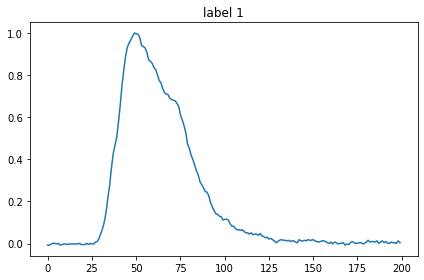

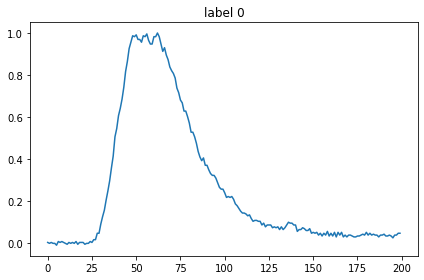

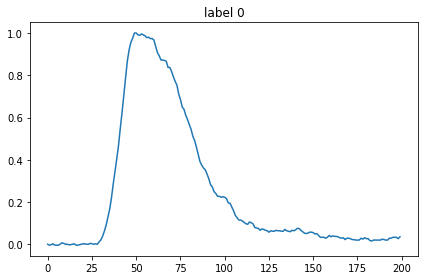

In [ ]:
# plot a few events
for i in range(10):
    fig, ax = plt.subplots(1, 1)
    ax.plot(data_train[i,:,0])
    ax.set_title(f"label {labels_train[i]}")
    fig.tight_layout()
    plt.show()
    plt.close("all")

In [ ]:
import os
path = os.path.join('saved_models')
if not os.path.exists(path):
    os.makedirs(path)

Now we can define the neural network and train it.

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Conv1D, Flatten, Dropout
from tensorflow.keras.layers import Dense, Conv2D, BatchNormalization, Activation
from tensorflow.keras.layers import AveragePooling2D, AveragePooling1D, Input, Flatten, MaxPooling1D, GlobalAveragePooling1D, GlobalMaxPooling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model
from tensorflow.keras.utils import Sequence
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import CSVLogger
import pickle

if 1:
    model = Sequential()
    model.add(Flatten(input_shape=(samples_per_pulse, 1)))
    model.add(Dense(100, activation="relu"))
    model.add(Dense(10, activation="relu"))
    model.add(Dense(1, activation="sigmoid"))
if 0:
    model = Sequential()
    model.add(Conv1D(64, 5, padding='valid', activation='relu', input_shape=(samples_per_pulse, 1)))
    model.add(Conv1D(64, 5, padding='valid', activation='relu'))
    model.add(Conv1D(64, 5, padding='valid', activation='relu'))
    # model.add(Conv1D(100, 5, padding='valid', activation='relu'))
    model.add(MaxPooling1D(2))
    model.add(Conv1D(128, 5, padding='valid', activation='relu'))
    model.add(Conv1D(128, 5, padding='valid', activation='relu'))
    # model.add(Conv1D(200, 5, padding='valid', activation='relu'))
    model.add(MaxPooling1D(2))
    model.add(Conv1D(256, 5, padding='valid', activation='relu'))
    model.add(Conv1D(256, 5, padding='valid', activation='relu'))
    model.add(MaxPooling1D(2))
    # model.add(Conv1D(400, 5, padding='valid', activation='relu'))
    # model.add(GlobalMaxPooling1D())
    model.add(Flatten())
    # model.add(Dense(1024))
    # model.add(Activation('relu'))
    model.add(Dense(256))
    model.add(Activation('relu'))
    model.add(Dense(128))
    model.add(Dense(1, activation="sigmoid"))
model.compile(loss='binary_crossentropy',
              optimizer=Adam(lr=1e-4),
              metrics=["accuracy"])
model.summary()

checkpoint = ModelCheckpoint(filepath=os.path.join('saved_models', "model_best.h5"),
                                                   monitor='val_accuracy',
                             verbose=1,
                             save_best_only=True, mode='auto',
                             save_weights_only=False)
csv_logger = CSVLogger(os.path.join('saved_models', "model_history_log.csv"), append=True)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5)



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 200)               0         
                                                                 
 dense (Dense)               (None, 100)               20100     
                                                                 
 dense_1 (Dense)             (None, 10)                1010      
                                                                 
 dense_2 (Dense)             (None, 1)                 11        
                                                                 
Total params: 21,121
Trainable params: 21,121
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
# let's train the network
history = model.fit(x=data_train, y=labels_train, batch_size=32, validation_split=0.2, epochs=200,
          callbacks=[checkpoint, csv_logger, early_stopping])

Epoch 1/200
543/545 [============================>.] - ETA: 0s - loss: 0.4938 - accuracy: 0.8095
Epoch 1: val_accuracy improved from -inf to 0.96350, saving model to saved_models/model_best.h5
545/545 [==============================] - 7s 10ms/step - loss: 0.4934 - accuracy: 0.8099 - val_loss: 0.3171 - val_accuracy: 0.9635
Epoch 2/200
542/545 [============================>.] - ETA: 0s - loss: 0.2260 - accuracy: 0.9673
Epoch 2: val_accuracy improved from 0.96350 to 0.97176, saving model to saved_models/model_best.h5
545/545 [==============================] - 4s 8ms/step - loss: 0.2254 - accuracy: 0.9675 - val_loss: 0.1618 - val_accuracy: 0.9718
Epoch 3/200
540/545 [============================>.] - ETA: 0s - loss: 0.1519 - accuracy: 0.9701
Epoch 3: val_accuracy did not improve from 0.97176
545/545 [==============================] - 4s 7ms/step - loss: 0.1522 - accuracy: 0.9700 - val_loss: 0.1345 - val_accuracy: 0.9715
Epoch 4/200
544/545 [============================>.] - ETA: 0s - loss

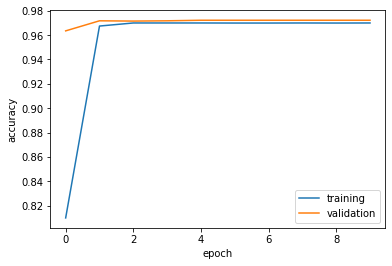

In [ ]:
# print training curve
fig, ax = plt.subplots(1, 1)
ax.plot(history.history['accuracy'], label="training")
ax.plot(history.history['val_accuracy'], label="validation")
ax.set_xlabel("epoch")
ax.set_ylabel("accuracy")
ax.legend()
plt.show()

The next step is to evaluate the performance of the neural network. Useful plots are a histogram of the neural network output of the two categories (gamma or neutron)

63/63 [==============================] - 0s 2ms/step


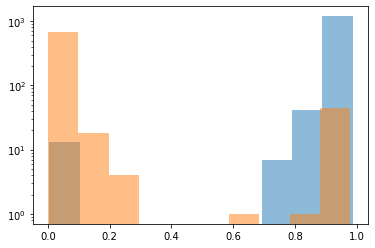

63/63 [==============================] - 0s 1ms/step
neutrons identified as neutrons 0.9367
gamma identified as gamma 0.9896


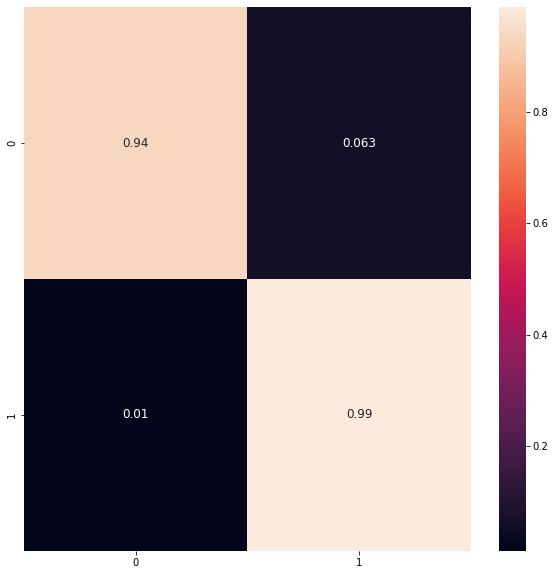

In [ ]:
# load the best performing epoch (because we implemented early stopping, the last epoch might not be the best)
model = keras.models.load_model(os.path.join('saved_models', "model_best.h5"))



model.evaluate(data_test, labels_test)

y_pred = model.predict(data_test)
smask = labels_test == 1
plt.hist(y_pred[smask], log=True, alpha=0.5)
plt.hist(y_pred[~smask], log=True, alpha=0.5)
plt.show()
#
ypred = model.predict(data_test)[:,0]
ypred_binary = np.zeros(len(ypred), dtype=int)
ypred_binary[ypred > 0.5] = 1

n_mask = labels_test == 0
true_n_rate = np.sum(ypred_binary[n_mask] == 0) / np.sum(n_mask)
print(f"neutrons identified as neutrons {true_n_rate:.4f}")
g_mask = labels_test == 1
true_g_rate = np.sum(ypred_binary[g_mask] == 1) / np.sum(g_mask)
print(f"gamma identified as gamma {true_g_rate:.4f}")

from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

cm = confusion_matrix(labels_test, ypred_binary, normalize='true')
cm = pd.DataFrame(cm, range(2),range(2))
plt.figure(figsize = (10,10))
sns.heatmap(cm, annot=True, annot_kws={"size": 12}) # font size
plt.show()


We find that the classification accuracy is independent of the network size. Even with a simple linear regression we find that 93.5% of the neutrons are classified correctly, and 99% of the gammas are classified correctly.

The reason for that is the training data set itself. The labels of the dataset are not perfect but have uncertainties. Not all neutrons are correctly labelled as neutrons and not all gammas are labelled as gammas. We can estimate the misclassification percentage by haveing a closer look at the time-of-flight histogram.

There is a constant background of counts for all times. We can use an interval far away from the gamma and neutron peaks to estimate its contribution, and then calculate its relative percentage of the number of counts inside the gamma/neutron peak.

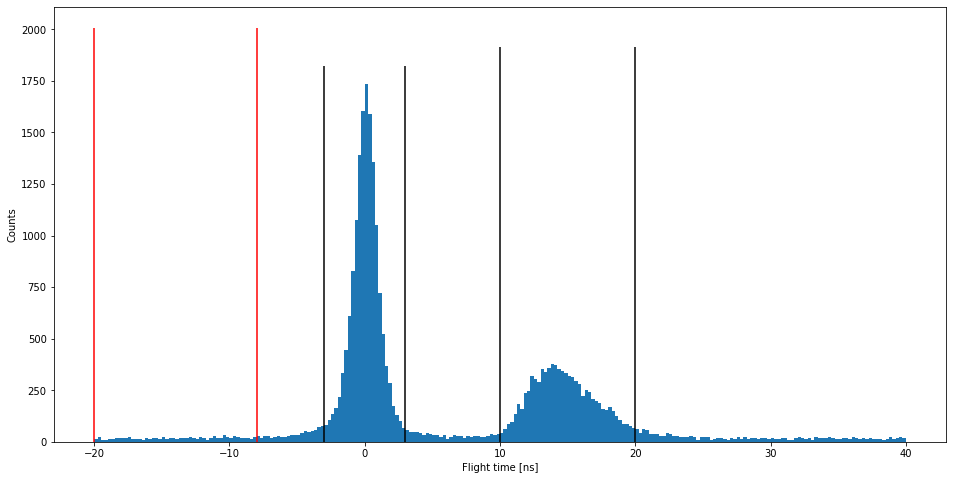

N_gamma 2514.8/ns, N_neutron 869.0/ns, N_bg 72.1/ns
gamma background contamination: 2.87% to be compared to gamma misclassification 1.0% -> if our classifier was perfect, it would mean that the background consist of 36.1% neutrons and 63.9% gammas
neutron background contamination: 8.29% to be compared to gamma misclassification 6.3% -> if our classifier was perfect, it would mean that the background consist of 23.7% neutrons and 76.3% gammas


In [ ]:
times = times[(times>=min_tof) & (times<=max_tof)]
# Now create a figure
fig, ax  = plt.subplots(figsize=(16,8))
ax.hist(times, bins=240)   # high resolution: 4 bins per nanosecond
ax.set_xlabel('Flight time [ns]')
ax.set_ylabel('Counts')

# plot the time intervals uses for gammas and neutrons
ax.vlines([gamma_min_tof, gamma_max_tof], 0, ax.get_ylim()[1])
ax.vlines([neutron_min_tof, neutron_max_tof], 0, ax.get_ylim()[1])

background_min_tof=-20
background_max_tof=-8
ax.vlines([background_min_tof, background_max_tof], 0, ax.get_ylim()[1], color="red")
plt.show()

# now we can calculate the `events density`, i.e., the number of counts per unit time in each interval. It is important
# that we normalize to the same time interval.
N_gamma = np.sum((times >= gamma_min_tof) & (times <= gamma_max_tof)) / (gamma_max_tof - gamma_min_tof)
N_neutron = np.sum((times >= neutron_min_tof) & (times <= neutron_max_tof)) / (neutron_max_tof - neutron_min_tof)
N_bg = np.sum((times >= background_min_tof) & (times <= background_max_tof)) / (background_max_tof - background_min_tof)
print(f"N_gamma {N_gamma:.1f}/ns, N_neutron {N_neutron:.1f}/ns, N_bg {N_bg:.1f}/ns")
print(f"gamma background contamination: {N_bg/N_gamma*100:.2f}% to be compared to gamma misclassification {(1-true_g_rate)*100:.1f}% -> if our classifier was perfect, it would mean that the background consist of {(1-true_g_rate)/(N_bg/N_gamma)*100:.1f}% neutrons and {(N_bg/N_gamma - (1-true_g_rate))*100/(N_bg/N_gamma):.1f}% gammas")
print(f"neutron background contamination: {N_bg/N_neutron*100:.2f}% to be compared to neutron misclassification {(1-true_n_rate)*100:.1f}% -> if our classifier was perfect, it would mean that the background consist of {(N_bg/N_neutron - (1-true_n_rate))*100/(N_bg/N_neutron):.1f}% neutrons and {(1-true_n_rate)*100/(N_bg/N_neutron):.1f}% gammas")


We can check this hypothesis by evaluating the network on the background to see how it is classified.

In [ ]:
bgdata = data_raw[(data_raw[:,1] >= background_min_tof) & (data_raw[:,1] <= background_max_tof)]
bgpulses = bgdata[:,2:]
bgpulses = (bgpulses-baseline)
bgpulses /= np.min(bgpulses, axis=-1, keepdims=True)
bgpulses = bgpulses[:, 150:350]
bgpulses = bgpulses[:,:, np.newaxis]
ypred = model.predict(bgpulses)[:,0]
ypred_binary = np.zeros(len(ypred), dtype=int)
ypred_binary[ypred > 0.5] = 1

gamma_fraction = np.sum(ypred_binary)/len(bgpulses)
neutron_fraction = np.sum(1-ypred_binary)/len(bgpulses)
print(f"classification of background: {gamma_fraction*100:.1f}% gammas and {neutron_fraction*100:.1f}% neutrons")

28/28 [==============================] - 0s 1ms/step
classification of background: 70.9% gammas and 29.1% neutrons


We find similar results to our previous estimate. This indicates that our classifier works much better than the accuracy derived from the test data set. Another hint is that the histogram of the network output shows two distinct distributions, i.e., one distribution close to zero, and the other one close to 1 with a gap between them.

We can increase the classification performance by defining a smaller time window around the gamma and neutron peak. This increases the signal to noise ratio and leads to a better classification accuracy.